In [1]:
import numpy
import spacy

print(f"Numpy version: {numpy.__version__}")
nlp = spacy.load("en_core_web_sm")
print("Spacy model loaded successfully!")

Numpy version: 1.23.5
Spacy model loaded successfully!


In [3]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_price_range_dynamic(user_input):
    """
    Dynamically extract price range from user input without relying heavily on specific keywords.
    """
    doc = nlp(user_input)
    price_range = {"MinPrice": None, "MaxPrice": None}

    # Variables to help interpret numeric context
    lower_bound = None
    upper_bound = None
    range_detected = False

    # Iterate through tokens to understand price-related contexts
    for token in doc:
        # Check if token is a valid number or MONEY-related entity
        if token.like_num or token.ent_type_ == "MONEY":
            # Attempt to convert token to a numeric value
            try:
                value = float(token.text.replace("$", "").replace(",", "").replace("k", "000").strip())
            except ValueError:
                continue  # Skip tokens that cannot be converted to numbers
            
            # Check the context around the number
            if token.head.text in ["under", "below", "less"]:
                upper_bound = value
            elif token.head.text in ["over", "above", "more"]:
                lower_bound = value
            elif token.head.text == "between" or token.head.text == "from":
                # Handle range start
                lower_bound = value
                range_detected = True
            elif range_detected and token.dep_ in ["conj", "cc"]:  # Handle range end
                upper_bound = value

        # Interpret qualitative terms (e.g., "cheap", "luxury") dynamically
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000  # Example threshold for cheap range
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000  # Example threshold for luxury range

    # Set the price range
    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound

    return price_range

# Test cases
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
]

for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)


Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': None, 'MaxPrice': None}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costing more t

In [17]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_price_range_dynamic(user_input):
    """
    Extract price range dynamically from user input.
    """
    doc = nlp(user_input)
    price_range = {"MinPrice": None, "MaxPrice": None}

    def parse_number(text):
        """
        Parse numbers from text, handling cases like "$20k", "20 000", or "50000$".
        """
        try:
            text = text.lower().replace("k", "000").replace("$", "").replace(",", "").replace(" ", "").strip("?.!")
            return float(text)
        except ValueError:
            return None

    lower_bound = None
    upper_bound = None
    in_range = False  # To track "between" or "to" ranges
    last_number = None

    for token in doc:
        value = parse_number(token.text)

        # If a numeric value is detected
        if value is not None:
            last_number = value
            if in_range:
                if lower_bound is None:
                    lower_bound = value
                else:
                    upper_bound = value
                in_range = False
            elif token.head.text in ["under", "below", "less", "than"]:
                upper_bound = value
            elif token.head.text in ["over", "above", "more", "than"]:
                lower_bound = value
            elif token.head.text in ["between", "to", "and"] or token.text in ["to", "and"]:
                in_range = True
            elif token.head.text in ["for", "within", "around"] and upper_bound is None:
                upper_bound = value

        # Handle qualitative terms like "cheap" or "luxury"
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000

    # Ensure logical consistency
    if lower_bound and upper_bound and lower_bound > upper_bound:
        lower_bound, upper_bound = upper_bound, lower_bound

    # Assign final bounds
    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound
    return price_range

# Test cases
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
    "Can I get something for $40,000?",
    "Is $20k to $50k within my range?",
    "I am looking for a car that costs less than 50000$?",
    "My budget is 20,000$",
    "I prefer below 15,000",
]

for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)


Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': None, 'MaxPrice': None}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 15000.0}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costing more

In [16]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_price_range_dynamic(user_input):
    doc = nlp(user_input)
    price_range = {"MinPrice": None, "MaxPrice": None}

    def parse_number(text):
        """
        Parse numbers from text, handling cases like "$20k", "20 000", or "50000$".
        """
        try:
            text = text.lower().replace("k", "000").replace("$", "").replace(",", "").replace(" ", "").strip("?.!")
            return float(text)
        except ValueError:
            return None

    lower_bound = None
    upper_bound = None
    in_range = False  # Tracks if we're inside a range context

    for token in doc:
        value = parse_number(token.text)

        if value is not None:  # Numeric or money-related token
            head = token.head.text.lower()
            grandparent = token.head.head.text.lower()

            # Case 1: Ranges (e.g., "between $20,000 and $50,000")
            if in_range:
                if lower_bound is None:
                    lower_bound = value
                else:
                    upper_bound = value
                in_range = False  # Reset range flag

            # Case 2: Contextual comparison
            elif head == "than" and grandparent == "more":
                lower_bound = value
            elif head == "than" and grandparent == "less":
                upper_bound = value
            elif head in ["under", "below", "less"]:
                upper_bound = value
            elif head in ["over", "above", "more"]:
                lower_bound = value

            # Case 3: Standalone "to", "and" in ranges
            elif head in ["between", "to", "and"] or token.text in ["to", "and"]:
                in_range = True

            # Case 4: Default assignment (e.g., "for $30,000")
            elif head in ["for", "within", "around"] and upper_bound is None:
                upper_bound = value

        # Case 5: Handle qualitative terms like "cheap" or "luxury"
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000

    # Ensure logical consistency
    if lower_bound and upper_bound and lower_bound > upper_bound:
        lower_bound, upper_bound = upper_bound, lower_bound

    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound
    return price_range

# Test cases
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
    "Can I get something for $40,000?",
    "Is $20k to $50k within my range?",
    "I am looking for a car that costs less than 50000$?",
    "My budget is 20,000$",
    "I prefer below 15,000",
    "Show me cars costing between $25,000 and $30,000.",
    "Cars over $50k and below $100k are my preference.",
]

for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)


Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': None, 'MaxPrice': None}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 15000.0}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costing more

In [20]:
import spacy
from spacy.tokens import Span

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def merge_currency(doc):
    """
    Merge currency symbols like $ with adjacent numbers into a single token.
    """
    with doc.retokenize() as retokenizer:
        spans = []
        for i, token in enumerate(doc[:-1]):  # Avoid index out of bounds
            if token.text in ["$", "€", "£"] and doc[i + 1].like_num:
                span = doc[token.i : token.i + 2]  # Create span for "$ 20,000"
                spans.append(span)
        for span in spans:
            retokenizer.merge(span)

def extract_price_range_dynamic(user_input):
    doc = nlp(user_input)
    merge_currency(doc)  # Merge currency symbols and numbers

    price_range = {"MinPrice": None, "MaxPrice": None}

    def parse_number(text):
        """
        Parse numbers from text, handling cases like "$20k", "20 000", or "50000$".
        """
        try:
            text = text.lower().replace("k", "000").replace("$", "").replace(",", "").replace(" ", "").strip("?.!")
            return float(text)
        except ValueError:
            return None

    lower_bound = None
    upper_bound = None
    in_range = False  # Tracks if we're inside a range context
    next_value_as_min = False  # Tracks if the next value should be assigned as MinPrice

    for token in doc:
        value = parse_number(token.text)

        # Explicit handling for "between" ranges
        if token.text.lower() == "between":
            in_range = True
            continue

        if value is not None:  # Numeric or money-related token
            head = token.head.text.lower()
            grandparent = token.head.head.text.lower()

            # Case 1: Ranges triggered by "between" + "and/to"
            if in_range:
                if lower_bound is None:
                    lower_bound = value
                elif upper_bound is None:
                    upper_bound = value
                    in_range = False  # Reset range flag
                continue

            # Case 2: Handle direct contextual comparison
            if head in ["than"]:
                if token.head.head.text.lower() in ["more"]:
                    lower_bound = value
                elif token.head.head.text.lower() in ["less"]:
                    upper_bound = value
            elif head in ["under", "below", "less"]:
                upper_bound = value
            elif head in ["over", "above", "more"]:
                lower_bound = value

            # Case 3: Standalone "to", "and" in ranges
            elif token.text in ["to", "and"]:
                next_value_as_min = True
            elif next_value_as_min:
                lower_bound = value
                next_value_as_min = False

            # Case 4: Default assignment (e.g., "for $30,000")
            elif head in ["for", "within", "around"]:
                upper_bound = value

        # Case 5: Handle qualitative terms like "cheap" or "luxury"
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000

    # Ensure logical consistency
    if lower_bound and upper_bound and lower_bound > upper_bound:
        lower_bound, upper_bound = upper_bound, lower_bound

    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound
    return price_range

# Test cases
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
    "Can I get something for $40,000?",
    "Is $20k to $50k within my range?",
    "I am looking for a car that costs less than 50000$?",
    "My budget is 20,000$",
    "I prefer below 15,000",
    "Show me cars costing between $25,000 and $30,000.",
    "Cars over $50k and below $100k are my preference.",
]

for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)


Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': 20000.0, 'MaxPrice': 50000.0}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 15000.0}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costin

In [23]:
import spacy
from spacy.tokens import Span

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

def merge_currency(doc):
    """
    Merge currency symbols like $ with adjacent numbers into a single token.
    """
    with doc.retokenize() as retokenizer:
        spans = []
        for i, token in enumerate(doc[:-1]):  # Avoid index out of bounds
            if token.text in ["$", "€", "£"] and doc[i + 1].like_num:
                span = doc[token.i : token.i + 2]  # Create span for "$ 20,000"
                spans.append(span)
        for span in spans:
            retokenizer.merge(span)

def extract_price_range_dynamic(user_input):
    doc = nlp(user_input)
    merge_currency(doc)  # Merge currency symbols and numbers

    price_range = {"MinPrice": None, "MaxPrice": None}

    def parse_number(text):
        """
        Parse numbers from text, handling cases like "$20k", "20 000", or "50000$".
        """
        try:
            text = text.lower().replace("k", "000").replace("$", "").replace(",", "").replace(" ", "").strip("?.!")
            return float(text)
        except ValueError:
            return None

    lower_bound = None
    upper_bound = None
    in_range = False  # Tracks if we're inside a range context

    for token in doc:
        value = parse_number(token.text)

        # Explicit handling for "between" ranges
        if token.text.lower() == "between":
            in_range = True
            continue

        if value is not None:  # Numeric or money-related token
            head = token.head.text.lower()
            grandparent = token.head.head.text.lower()

            # Case 1: Ranges triggered by "between" + "and/to"
            if in_range:
                if lower_bound is None:
                    lower_bound = value
                elif upper_bound is None:
                    upper_bound = value
                    in_range = False  # Reset range flag
                continue

            # Case 2: Handle direct contextual comparison
            if head in ["than"]:
                if token.head.head.text.lower() in ["more", "above"]:
                    lower_bound = value
                elif token.head.head.text.lower() in ["less", "below"]:
                    upper_bound = value
            elif head in ["under", "below", "less"]:
                upper_bound = value
            elif head in ["over", "above", "more"]:
                lower_bound = value

            # Case 3: Standalone "to", "and" in ranges
            elif token.text in ["to", "and"]:
                if lower_bound is None:
                    lower_bound = value
                else:
                    upper_bound = value

            # Case 4: Default assignment (e.g., "for $30,000")
            elif head in ["for", "within", "around"]:
                upper_bound = value

        # Case 5: Handle qualitative terms like "cheap" or "luxury"
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000

    # Ensure logical consistency
    if lower_bound and upper_bound and lower_bound > upper_bound:
        lower_bound, upper_bound = upper_bound, lower_bound

    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound
    return price_range

# Test cases
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
    "Can I get something for $40,000?",
    "Is $20k to $50k within my range?",
    "I am looking for a car that costs less than 50000$?",
    "My budget is 20,000$",
    "I prefer below 15,000",
    "Show me cars costing between $25,000 and $30,000.",
    "Cars over $50k and below $100k are my preference.",
]

for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)


Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': 20000.0, 'MaxPrice': 50000.0}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 15000.0}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costin

In [32]:
def extract_price_range_dynamic(user_input):
    doc = nlp(user_input)
    merge_currency(doc)

    price_range = {"MinPrice": None, "MaxPrice": None}

    def parse_number(text):
        try:
            text = text.lower().replace("k", "000").replace("$", "").replace(",", "").replace(" ", "").strip("?.!")
            return float(text)
        except ValueError:
            return None

    lower_bound = None
    upper_bound = None
    in_range = False
    single_number_encountered = False  # Flag for single numbers without context

    for token in doc:
        value = parse_number(token.text)

        # Handle range keywords like "between"
        if token.text.lower() == "between":
            in_range = True
            continue

        if value is not None:  # Numeric token
            # Check immediate head and ancestors
            head = token.head.text.lower()
            ancestors = [ancestor.text.lower() for ancestor in token.ancestors]
            children = [child.text.lower() for child in token.children]  # Include children for better context

            # Handle "more than", "less than" by looking at ancestors and children
            if ("more" in ancestors or "above" in ancestors or "over" in ancestors) and "than" in ancestors:
                lower_bound = value
            elif ("less" in ancestors or "below" in ancestors or "under" in ancestors) and "than" in ancestors:
                upper_bound = value

            # Handle explicit range
            elif in_range:
                if lower_bound is None:
                    lower_bound = value
                else:
                    upper_bound = value
                    in_range = False

            # Handle standalone comparison keywords
            elif head in ["under", "below", "less"]:
                upper_bound = value
            elif head in ["over", "above", "more"]:
                lower_bound = value

            # Handle ranges connected by "to", "and"
            elif token.text in ["to", "and"]:
                if lower_bound is None:
                    lower_bound = value
                else:
                    upper_bound = value

            # Default catch for exact values
            elif head in ["for", "within", "around"]:
                upper_bound = value

            # If no context is found, treat the number as an upper bound by default
            else:
                single_number_encountered = True
                upper_bound = value

        # Handle qualitative terms like "cheap" or "luxury"
        elif token.lemma_ in ["cheap", "affordable"]:
            upper_bound = 20000
        elif token.lemma_ in ["luxury", "expensive"]:
            lower_bound = 50000

    # Swap bounds if lower > upper
    if lower_bound and upper_bound and lower_bound > upper_bound:
        lower_bound, upper_bound = upper_bound, lower_bound

    # If a single number was encountered without context, assign it as an upper bound
    if single_number_encountered and lower_bound is None and upper_bound is None:
        upper_bound = value

    price_range["MinPrice"] = lower_bound
    price_range["MaxPrice"] = upper_bound
    return price_range


In [34]:
examples = [
    "I'm looking for a car under $40,000.",
    "Do you have anything between $20,000 and $50,000?",
    "I want an affordable car.",
    "Show me luxury cars over $70,000.",
    "Give me a cheap vehicle under $15k.",
    "I need a car below $25,000 but above $10,000.",
    "I’m searching for something costing more than 50k.",
    "What can I get for less than $30,000?",
    "Can I get something for $40,000?",
    "Is $20k to $50k within my range?",
    "I am looking for a car that costs less than 50000$?",
    "My budget is 20,000$",
    "I prefer below 15,000",
    "Show me cars costing between $25,000 and $30,000.",
    "Cars over $50k and below $100k are my preference.",
]
for example in examples:
    result = extract_price_range_dynamic(example)
    print(f"Input: {example}")
    print(f"Extracted Price Range: {result}")
    print("-" * 50)

Input: I'm looking for a car under $40,000.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 40000.0}
--------------------------------------------------
Input: Do you have anything between $20,000 and $50,000?
Extracted Price Range: {'MinPrice': 20000.0, 'MaxPrice': 50000.0}
--------------------------------------------------
Input: I want an affordable car.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 20000}
--------------------------------------------------
Input: Show me luxury cars over $70,000.
Extracted Price Range: {'MinPrice': 70000.0, 'MaxPrice': None}
--------------------------------------------------
Input: Give me a cheap vehicle under $15k.
Extracted Price Range: {'MinPrice': None, 'MaxPrice': 15000.0}
--------------------------------------------------
Input: I need a car below $25,000 but above $10,000.
Extracted Price Range: {'MinPrice': 10000.0, 'MaxPrice': 25000.0}
--------------------------------------------------
Input: I’m searching for something costin

In [47]:
def extract_colors(user_input):
    # List of unique colors
    UNIQUE_COLORS = ['White', 'Gray', 'Black', 'Silver', 'Red', 'Blue', 
                     'Green', 'Gold', 'Copper', 'Brown', 'Orange', 'Tan', 
                     'Teal', 'Yellow', 'Maroon']

    # Define darker and lighter color groups
    DARK_COLORS = ['Black', 'Gray', 'Navy', 'Charcoal', 'Brown', 'Maroon', 'Dark Green']
    LIGHT_COLORS = ['White', 'Silver', 'Yellow', 'Beige', 'Light Gray', 'Light Blue', 'Pale Orange']

    # Synonyms for tone-related words
    TONE_MAP = {
        "dark": "dark",
        "light": "light",
        "bright": "light",
        "deep": "dark",
        "pale": "light",
    }

    # Synonyms for colors
    COLOR_SYNONYMS = {
        "grey": "Gray",
        "charcoal": "Black",
        "scarlet": "Red",
        "navy": "Blue",
        "emerald": "Green",
        "golden": "Gold",
        "bronze": "Copper",
        "chocolate": "Brown",
        "amber": "Orange",
        "beige": "Tan",
        "turquoise": "Teal",
        "lemon": "Yellow",
        "burgundy": "Maroon",
    }

    # Reverse mapping for quick lookup
    COLOR_MAP = {color.lower(): color for color in UNIQUE_COLORS}
    for synonym, base_color in COLOR_SYNONYMS.items():
        COLOR_MAP[synonym.lower()] = base_color

    doc = nlp(user_input)
    detected_colors = []
    match_dark = False
    match_light = False
    explicit_color_found = False

    for token in doc:
        token_text = token.text.lower()

        # Check for tone keywords ("dark", "light") with broader context
        if token_text in TONE_MAP:
            tone = TONE_MAP[token_text]
            if tone == "dark":
                match_dark = True
            elif tone == "light":
                match_light = True

        # Check if the token matches any color or synonym
        if token_text in COLOR_MAP:
            base_color = COLOR_MAP[token_text]
            detected_colors.append(base_color)
            explicit_color_found = True

        # Handle tone + color combination (e.g., "dark blue")
        if token_text in TONE_MAP:
            for child in token.children:
                child_text = child.text.lower()
                if child_text in COLOR_MAP:
                    base_color = COLOR_MAP[child_text]
                    detected_colors.append(base_color)
                    explicit_color_found = True

    # If no specific color is mentioned but tone is detected, use dark/light groups
    if not explicit_color_found:
        if match_dark:
            detected_colors.extend(DARK_COLORS)
        if match_light:
            detected_colors.extend(LIGHT_COLORS)

    # Remove duplicates and preserve order
    detected_colors = list(dict.fromkeys(detected_colors))

    return detected_colors


In [48]:
examples = [
    "I want a dark blue car.",
    "Do you have something in red or green?",
    "Show me vehicles in navy, charcoal, or turquoise.",
    "I prefer a bright yellow or pale orange car.",
    "Give me a car that's emerald or burgundy.",
    "I'm looking for a car in dark gray or light silver.",
    "Show me darker colors.",
    "Do you have lighter shades?",
    "I want a car in dark or bright colors.",
    "I’m interested in light-colored cars.",
]

for example in examples:
    result = extract_colors(example)
    print(f"Input: {example}")
    print(f"Extracted Colors: {result}")
    print("--------------------------------------------------")


Input: I want a dark blue car.
Extracted Colors: ['Blue']
--------------------------------------------------
Input: Do you have something in red or green?
Extracted Colors: ['Red', 'Green']
--------------------------------------------------
Input: Show me vehicles in navy, charcoal, or turquoise.
Extracted Colors: ['Blue', 'Black', 'Teal']
--------------------------------------------------
Input: I prefer a bright yellow or pale orange car.
Extracted Colors: ['Yellow', 'Orange']
--------------------------------------------------
Input: Give me a car that's emerald or burgundy.
Extracted Colors: ['Green', 'Maroon']
--------------------------------------------------
Input: I'm looking for a car in dark gray or light silver.
Extracted Colors: ['Gray', 'Silver']
--------------------------------------------------
Input: Show me darker colors.
Extracted Colors: []
--------------------------------------------------
Input: Do you have lighter shades?
Extracted Colors: []
----------------------

In [2]:
from transformers import pipeline

qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased")

# Example usage:
input_text = "I'm looking for a red car under $40,000."
question = "What color is the user looking for?"
color = qa_pipeline({"context": input_text, "question": question})['answer']

print("Extracted Color:", color)


c:\Users\karim\OneDrive\Desktop\CODEJAM14Repo\CodeJam14KKSB\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\karim\OneDrive\Desktop\CODEJAM14Repo\CodeJam14KKSB\venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\karim\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or t

Extracted Color: 40


In [18]:
nlp = spacy.blank("en")
# Add NER pipeline
ner = nlp.add_pipe("ner")

# Add labels
ner.add_label("PRICE")
ner.add_label("COLOR")
ner.add_label("Body")

1

In [6]:
import spacy
from spacy.training import Example
from spacy.tokens import DocBin

# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Define your training examples with correct entity offsets
examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (24, 31, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(10, 14, "COLOR"), (15, 20, "Body"), (25, 32, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(20, 27, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (34, 41, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (33, 40, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (40, 47, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(41, 48, "PRICE"), (53, 60, "PRICE")]}),
    # Additional examples
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (47, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 59, "MILES"), (64, 79, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (38, 51, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (20, 27, "OPTIONS"), (32, 52, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (44, 61, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (34, 38, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 40, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 48, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 22, "Body"), (28, 48, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 40, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (40, 46, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 42, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (18, 39, "TRANSMISSION"), (44, 61, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 53, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(18, 25, "Body"), (39, 43, "YEAR"), (54, 67, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 38, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(14, 19, "Body"), (36, 43, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (50, 60, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (36, 43, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (36, 47, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 48, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (38, 49, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 45, "MILES"), (59, 66, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(14, 19, "Body"), (41, 52, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (32, 36, "YEAR"), (47, 54, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (34, 39, "YEAR"), (45, 54, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (43, 44, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 56, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (40, 47, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (29, 53, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 58, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (36, 43, "PRICE"), (49, 62, "OPTIONS")]}),
    # New examples covering additional columns
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
]

# Add labels to the NER component
for _, annotations in examples:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Begin training
import random
from spacy.util import minibatch, compounding

with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for iteration in range(100):
        random.shuffle(examples)
        losses = {}
        batches = minibatch(examples, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
        print(f"Iteration {iteration + 1}, Loss: {losses['ner']}")

# Save the model
nlp.to_disk("custom_ner_model")


/Users/khaledabusalma/hackathon/CodeJam14KKSB/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I currently drive a 2018 Toyota Camry. Do you have..." with entities "[(19, 23, 'YEAR'), (24, 30, 'MAKE'), (31, 36, 'MOD...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/khaledabusalma/hackathon/CodeJam14KKSB/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Find me a vehicle with a fuel efficiency of at lea..." with entities "[(9, 16, 'BODY_TYPE'), (44, 56, 'HighwayMPG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/khaledabusalma/hackathon/CodeJam14KKSB/v

Iteration 1, Loss: 238.62152099609375
Iteration 2, Loss: 117.63455200195312
Iteration 3, Loss: 88.57211303710938
Iteration 4, Loss: 68.0566635131836
Iteration 5, Loss: 77.4425048828125
Iteration 6, Loss: 62.8074836730957
Iteration 7, Loss: 51.01408767700195
Iteration 8, Loss: 37.312137603759766
Iteration 9, Loss: 33.6988525390625
Iteration 10, Loss: 32.992950439453125
Iteration 11, Loss: 49.91193389892578
Iteration 12, Loss: 22.367185592651367
Iteration 13, Loss: 33.716102600097656
Iteration 14, Loss: 18.38157844543457
Iteration 15, Loss: 27.877811431884766
Iteration 16, Loss: 18.568744659423828
Iteration 17, Loss: 17.4156551361084
Iteration 18, Loss: 36.502166748046875
Iteration 19, Loss: 21.582069396972656
Iteration 20, Loss: 14.76552963256836
Iteration 21, Loss: 17.268468856811523
Iteration 22, Loss: 14.36817455291748
Iteration 23, Loss: 15.519801139831543
Iteration 24, Loss: 13.571918487548828
Iteration 25, Loss: 8.55333423614502
Iteration 26, Loss: 23.025943756103516
Iteration 27,

In [7]:


import spacy

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Define test cases (only Q parts are used for entity extraction)
test_cases = [
    "I need a pickup truck with 4WD, leather seats, and under 50,000 km.",
    "Do you have a sporty car with a sunroof and under 50,000 km?",
    "Do you have a red convertible under 30,000 km?",
    "Do you have a family SUV with leather seats and low mileage?",
    "Do you have an electric car with a range of at least 300 miles and advanced safety features?",
    "I'm looking for an SUV with captain's chairs and a panoramic sunroof.",
    "Do you have a minivan with stow-and-go seating and rear-seat entertainment?",
    "I'm looking for a high-performance car with launch control and Brembo brakes.",
    "Do you have the car with VIN 1HGCM82633A123456?",
    "I'm looking for the car with VIN 5FNYF6H57LB789012.",
    "Do you have an SUV with off-road capabilities, a roof rack, and skid plates?",
    "Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?",
    "I'm looking for an SUV with third-row seating.",
    "Do you have a hybrid SUV?",
    "I want something fun to drive.",
    "I currently drive a 2018 Toyota Camry. Do you have anything similar?",
    "I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?",
    "I'm looking for a fun car to drive.",
    "I want an electric car.",
]

# Test the model with the cases
for i, sentence in enumerate(test_cases, start=1):
    doc = nlp(sentence)
    print(f"Test Case {i}:")
    print(f"Sentence: {sentence}")
    print("Entities:")
    for ent in doc.ents:
        print(f" - {ent.text}: {ent.label_}")
    print("\n" + "-"*50 + "\n")



Test Case 1:
Sentence: I need a pickup truck with 4WD, leather seats, and under 50,000 km.
Entities:
 - pickup truck: BODY_TYPE
 - 4WD: DRIVETRAIN
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 2:
Sentence: Do you have a sporty car with a sunroof and under 50,000 km?
Entities:
 - sporty: BODY_TYPE

--------------------------------------------------

Test Case 3:
Sentence: Do you have a red convertible under 30,000 km?
Entities:
 - red: COLOR
 - convertible: BODY_TYPE

--------------------------------------------------

Test Case 4:
Sentence: Do you have a family SUV with leather seats and low mileage?
Entities:
 - family SUV: BODY_TYPE
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 5:
Sentence: Do you have an electric car with a range of at least 300 miles and advanced safety features?
Entities:
 - electric: FUEL_TYPE
 - car: BODY_TYPE
 - safety: BODY_TYPE

----------------------------------------------

In [9]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import matplotlib.pyplot as plt

import spacy
from spacy.training import Example
from spacy.tokens import DocBin

# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Define your training examples with correct entity offsets
examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (24, 31, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(10, 14, "COLOR"), (15, 20, "Body"), (25, 32, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(20, 27, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (34, 41, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (33, 40, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (40, 47, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(41, 48, "PRICE"), (53, 60, "PRICE")]}),
    # Additional examples
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (47, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 59, "MILES"), (64, 79, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (38, 51, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (20, 27, "OPTIONS"), (32, 52, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (44, 61, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (34, 38, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 40, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 48, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 22, "Body"), (28, 48, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 40, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (40, 46, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 42, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (18, 39, "TRANSMISSION"), (44, 61, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 53, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(18, 25, "Body"), (39, 43, "YEAR"), (54, 67, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 38, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(14, 19, "Body"), (36, 43, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (50, 60, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (36, 43, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (36, 47, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 48, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (38, 49, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 45, "MILES"), (59, 66, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(14, 19, "Body"), (41, 52, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (32, 36, "YEAR"), (47, 54, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (34, 39, "YEAR"), (45, 54, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (43, 44, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 56, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (40, 47, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (29, 53, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 58, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (36, 43, "PRICE"), (49, 62, "OPTIONS")]}),
    # New examples covering additional columns
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
]

# Add labels to the NER component
for _, annotations in examples:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Begin training
import random
from spacy.util import minibatch, compounding

# Split data into training and validation sets
split = int(len(examples) * 0.8)
train_examples = examples[:split]
valid_examples = examples[split:]

# Initialize the optimizer
optimizer = nlp.create_optimizer()
optimizer.alpha = 0.001  # Smaller learning rate for Adam

# Tracking losses
train_losses = []
valid_losses = []

with nlp.disable_pipes(*other_pipes):
    for epoch in range(100):
        random.shuffle(train_examples)
        losses = {}
        # Batch up the examples using spaCy's minibatch
        batches = minibatch(train_examples, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
        train_losses.append(losses['ner'])
        
        # Evaluate on validation data
        with nlp.use_params(optimizer.averages):
            valid_loss = 0.0
            for text, annotations in valid_examples:
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                nlp.evaluate([example], losses=losses)
                valid_loss += losses.get('ner', 0.0)
            valid_losses.append(valid_loss)
        
        print(f"Epoch {epoch + 1}, Training Loss: {losses['ner']}, Validation Loss: {valid_loss}")

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

nlp.to_disk("custom_ner_model")


AttributeError: 'Optimizer' object has no attribute 'alpha'

In [11]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import matplotlib.pyplot as plt
from spacy.scorer import Scorer

# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Define your training examples with correct entity offsets
examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (24, 31, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(10, 14, "COLOR"), (15, 20, "Body"), (25, 32, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(20, 27, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (34, 41, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (33, 40, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (40, 47, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(41, 48, "PRICE"), (53, 60, "PRICE")]}),
    # Additional examples
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (47, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 59, "MILES"), (64, 79, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (38, 51, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (20, 27, "OPTIONS"), (32, 52, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (44, 61, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (34, 38, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 40, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 48, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 22, "Body"), (28, 48, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 40, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (40, 46, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 42, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (18, 39, "TRANSMISSION"), (44, 61, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 53, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(18, 25, "Body"), (39, 43, "YEAR"), (54, 67, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 38, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(14, 19, "Body"), (36, 43, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (50, 60, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (36, 43, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (36, 47, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 48, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (38, 49, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 45, "MILES"), (59, 66, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(14, 19, "Body"), (41, 52, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (32, 36, "YEAR"), (47, 54, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (34, 39, "YEAR"), (45, 54, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (43, 44, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 56, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (40, 47, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (29, 53, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 58, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (36, 43, "PRICE"), (49, 62, "OPTIONS")]}),
    # New examples covering additional columns
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
]

# Add labels to the NER component
for _, annotations in examples:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Split data into training and validation sets
split = int(len(examples) * 0.8)
train_examples = examples[:split]
valid_examples = examples[split:]

# Convert training examples to spaCy's Example objects
train_data = []
for text, annotations in train_examples:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    train_data.append(example)

valid_data = []
for text, annotations in valid_examples:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    valid_data.append(example)

# Create a custom configuration with a custom learning rate for the optimizer
config = {
    "training": {
        "optimizer": {
            "@optimizers": "Adam.v1",
            "learn_rate": 0.001,  # Set your desired learning rate here
        }
    }
}

# Initialize the NER component with the custom configuration
nlp.initialize(get_examples=lambda: train_data, config=config)

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Tracking losses and validation scores
train_losses = []
valid_f_scores = []

with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.optimizer  # Get the optimizer initialized with nlp.initialize()
    for epoch in range(100):
        random.shuffle(train_data)
        losses = {}
        # Batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            nlp.update(
                batch,
                sgd=optimizer,
                drop=0.35,
                losses=losses,
            )
        train_losses.append(losses.get('ner', 0.0))
        
        # Evaluate on validation data
        examples = []
        for example in valid_data:
            pred_doc = nlp(example.reference.text)
            examples.append(Example(predicted=pred_doc, reference=example.reference))
        scorer = Scorer()
        scores = scorer.score(examples)
        valid_f_scores.append(scores['ents_f'])
        
        print(f"Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation F-score: {valid_f_scores[-1]:.2f}")

# Plot the training loss and validation F-score
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_f_scores, label='Validation F-score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss and Validation F-score over Epochs')
plt.show()

# Save the model
nlp.to_disk("custom_ner_model")


/Users/khaledabusalma/hackathon/CodeJam14KKSB/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I'm looking for a 2018 Toyota Camry with less than..." with entities "[(18, 22, 'YEAR'), (23, 29, 'MAKE'), (30, 35, 'MOD...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/khaledabusalma/hackathon/CodeJam14KKSB/venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Do you have any electric SUVs?" with entities "[(16, 24, 'FUEL_TYPE'), (25, 28, 'BODY_TYPE')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/khaledabusalma/hackathon/CodeJam14KKSB/venv/lib/python3.12/site

TypeError: Language.initialize() got an unexpected keyword argument 'config'

In [18]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import matplotlib.pyplot as plt

# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
ner = nlp.add_pipe("ner")

examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (25, 32, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(8, 12, "COLOR"), (13, 18, "Body"), (24, 31, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(12, 15, "Body"), (29, 36, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (36, 43, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (37, 44, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (41, 48, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(42, 49, "PRICE"), (54, 61, "PRICE")]}),
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (46, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 60, "MILES"), (65, 80, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 53, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (19, 26, "OPTIONS"), (31, 51, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (46, 63, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (33, 37, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 42, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 49, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 23, "Body"), (34, 55, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 41, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (41, 47, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 46, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (19, 40, "TRANSMISSION"), (45, 62, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 54, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(12, 19, "Body"), (35, 39, "YEAR"), (51, 65, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 39, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(13, 18, "Body"), (39, 46, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (49, 59, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (40, 47, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (22, 53, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 51, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (39, 50, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 46, "MILES"), (62, 69, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(12, 17, "Body"), (36, 51, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (35, 39, "YEAR"), (50, 57, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (35, 41, "YEAR"), (47, 56, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (49, 50, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 58, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (44, 51, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (30, 54, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 59, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (35, 42, "PRICE"), (48, 62, "OPTIONS")]}),
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
        # Additional examples to balance underrepresented entities
    ("I want a car with a V8 engine.", {"entities": [(9, 12, "Body"), (20, 22, "EngineCylinders")]}),
    ("I'm interested in a certified pre-owned sedan.", {"entities": [(18, 38, "Certified"), (39, 44, "Body")]}),
    ("Do you have any cars with stock number 12345?", {"entities": [(16, 20, "Body"), (26, 44, "Stock")]}),
    ("I'm interested in a car with a wheelbase of 120 inches.", {"entities": [(18, 21, "Body"), (31, 54, "Wheelbase_Code")]}),
    ("I need a van that can seat 12 passengers.", {"entities": [(9, 12, "Body"), (27, 40, "PassengerCapacity")]}),
    ("I'm looking for a 4-door SUV.", {"entities": [(18, 24, "DOORS"), (25, 28, "Body")]}),
    ("I'm interested in a car that gets at least 25 MPG in the city.", {"entities": [(18, 21, "Body"), (43, 49, "CityMPG")]}),
    ("I need an SUV that gets at least 30 MPG on the highway.", {"entities": [(9, 12, "Body"), (43, 49, "HighwayMPG")]}),
    ("I prefer a car with manual transmission.", {"entities": [(10, 13, "Body"), (19, 38, "TRANSMISSION")]}),
    ("I need a car with an engine displacement of 2.0L.", {"entities": [(9, 12, "Body"), (18, 46, "EngineDisplacement")]}),
    ("Can you find the car with VIN number ABCD123456789?", {"entities": [(17, 20, "Body"), (26, 46, "VIN")]}),
    ("I'm interested in the 2020 Honda Accord.", {"entities": [(21, 25, "YEAR"), (26, 31, "MAKE"), (32, 38, "MODEL")]}),
    ("I'm looking for a diesel sedan.", {"entities": [(18, 24, "FUEL_TYPE"), (25, 30, "Body")]}),
    ("Show me trucks with a towing capacity over 5,000 lbs.", {"entities": [(8, 14, "Body"), (22, 51, "Engine_Description")]}),
    ("I need a coupe with a V6 engine.", {"entities": [(9, 14, "Body"), (22, 24, "EngineCylinders")]}),
    ("Do you have any vehicles with a 6-cylinder engine?", {"entities": [(16, 24, "Body"), (32, 43, "EngineCylinders")]}),
    ("I'm looking for a hybrid car with automatic transmission.", {"entities": [(18, 24, "FUEL_TYPE"), (25, 28, "Body"), (34, 53, "TRANSMISSION")]}),
    ("I need an SUV with a wheelbase longer than 115 inches.", {"entities": [(9, 12, "Body"), (20, 49, "Wheelbase_Code")]}),
    ("Do you have any certified vehicles in stock?", {"entities": [(16, 25, "Certified"), (26, 34, "Body")]}),
    ("Can you show me sedans with less than 20,000 miles?", {"entities": [(17, 23, "Body"), (37, 50, "MILES")]}),
    ("I'm interested in a 2-door convertible.", {"entities": [(18, 24, "DOORS"), (25, 36, "Body")]}),
    ("I want a minivan that can seat 8 people.", {"entities": [(9, 16, "Body"), (27, 35, "PassengerCapacity")]}),
    ("Do you have any cars with stock number XYZ789?", {"entities": [(16, 20, "Body"), (26, 42, "Stock")]}),
    ("I'm looking for a truck with a V6 engine.", {"entities": [(18, 23, "Body"), (31, 33, "EngineCylinders")]}),
    ("Can you find me a certified pre-owned SUV?", {"entities": [(18, 38, "Certified"), (39, 42, "Body")]}),
    ("I need a sedan with a fuel efficiency of at least 35 MPG city.", {"entities": [(9, 14, "Body"), (49, 59, "CityMPG")]}),
    ("I'm interested in an electric vehicle with a range of 250 miles.", {"entities": [(18, 26, "FUEL_TYPE"), (27, 34, "Body"), (47, 57, "MILES")]}),
    ("Do you have any SUVs with a manual transmission?", {"entities": [(16, 19, "Body"), (28, 47, "TRANSMISSION")]}),
    ("I want a car with a 4-cylinder engine.", {"entities": [(9, 12, "Body"), (20, 31, "EngineCylinders")]}),
    ("Looking for a vehicle with stock number LMN456.", {"entities": [(14, 21, "Body"), (27, 43, "Stock")]}),
    ("I'm interested in a vehicle with VIN JH4KA8260MC000000.", {"entities": [(18, 25, "Body"), (31, 50, "VIN")]}),
    ("I need a vehicle with at least 7 seats.", {"entities": [(9, 16, "Body"), (27, 34, "PassengerCapacity")]}),
    ("Do you have any vehicles with wheelbase between 110 and 120 inches?", {"entities": [(16, 24, "Body"), (30, 59, "Wheelbase_Code")]}),
    ("I'm looking for a truck with a diesel engine.", {"entities": [(18, 23, "Body"), (31, 37, "FUEL_TYPE"), (38, 44, "Engine_Description")]}),
    ("I prefer a sedan with high highway MPG.", {"entities": [(10, 15, "Body"), (26, 39, "HighwayMPG")]}),
    ("Can you find me a car with at least 400 horsepower?", {"entities": [(18, 21, "Body"), (32, 45, "Engine_Description")]}),
    ("I need a 4-door truck with off-road capabilities.", {"entities": [(9, 15, "DOORS"), (16, 21, "Body"), (27, 48, "OPTIONS")]}),
    ("Do you have any certified pre-owned cars?", {"entities": [(16, 38, "Certified"), (39, 43, "Body")]}),
    ("I'm looking for a vehicle with a hybrid drivetrain.", {"entities": [(18, 25, "Body"), (35, 41, "FUEL_TYPE"), (42, 51, "DRIVETRAIN")]}),
    ("I need a van with seating for 15 passengers.", {"entities": [(9, 12, "Body"), (26, 39, "PassengerCapacity")]}),
    ("Can you show me SUVs with stock number DEF123?", {"entities": [(17, 20, "Body"), (26, 42, "Stock")]}),
    ("I'm interested in a car with a 3.5L engine displacement.", {"entities": [(18, 21, "Body"), (29, 52, "EngineDisplacement")]}),
    ("Do you have any trucks with dual rear wheels?", {"entities": [(16, 22, "Body"), (28, 44, "OPTIONS")]}),
    ("I want an SUV with a towing capacity of 7,000 lbs.", {"entities": [(9, 12, "Body"), (20, 43, "Engine_Description")]}),
    ("Looking for a convertible with a V12 engine.", {"entities": [(14, 25, "Body"), (33, 36, "EngineCylinders")]}),
    ("I need a vehicle with a fuel efficiency of 100 MPGe.", {"entities": [(9, 16, "Body"), (37, 44, "HighwayMPG")]}),
    ("Do you have a hatchback with a sunroof and heated seats?", {"entities": [(13, 22, "Body"), (30, 37, "OPTIONS"), (42, 54, "OPTIONS")]}),
    ("I'm looking for a sports car with a convertible top.", {"entities": [(18, 28, "Body"), (36, 52, "OPTIONS")]}),
    ("I prefer an electric SUV with at least 200 miles of range.", {"entities": [(10, 18, "FUEL_TYPE"), (19, 22, "Body"), (34, 45, "MILES")]}),
]

# Add new labels to the NER component
for _, annotations in examples:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Convert training examples to spaCy's Example objects
training_data = []
for text, annotations in examples:
    doc = nlp.make_doc(text)
    entities = annotations.get("entities")
    valid_entities = []
    for start, end, label in entities:
        span = doc.char_span(start, end, label=label)
        if span is None:
            print(f"Entity '{text[start:end]}' in '{text}' could not be aligned.")
        else:
            valid_entities.append((span.start_char, span.end_char, label))
    annotations["entities"] = valid_entities
    example = Example.from_dict(doc, annotations)
    training_data.append(example)

# Update the entity counts
entity_counts = Counter()
for example in training_data:
    for ent in example.reference.ents:
        entity_counts[ent.label_] += 1
print("Updated Entity Counts:", entity_counts)

# Split data into training and validation sets
split = int(len(training_data) * 0.8)
train_data = training_data[:split]
valid_data = training_data[split:]

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# Begin training
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    # Set a random seed for reproducibility
    random.seed(42)
    spacy.util.fix_random_seed(42)
    optimizer.learn_rate = 0.001  # Adjust learning rate if needed

    # Tracking losses and validation scores
    train_losses = []
    valid_f_scores = []

    for epoch in range(100):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            nlp.update(
                batch,
                drop=0.5,  # Increased dropout rate to reduce overfitting
                losses=losses,
                sgd=optimizer
            )
        train_losses.append(losses.get('ner', 0.0))

        # Evaluate on validation data
        examples = []
        for example in valid_data:
            pred_doc = nlp(example.reference.text)
            examples.append(Example(predicted=pred_doc, reference=example.reference))
        # Calculate F-score
        scores = Scorer().score(examples)
        valid_f_scores.append(scores['ents_f'])

        print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]:.4f}, Validation F-score: {valid_f_scores[-1]:.2f}")

        # Early stopping (optional)
        if epoch > 5 and valid_f_scores[-1] < 0.2:
            print("Early stopping due to low validation F-score.")
            break

# Plot the training loss and validation F-score
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_f_scores, label='Validation F-score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss and Validation F-score over Epochs')
plt.show()

# Save the model
nlp.to_disk("custom_ner_model")

Entity 'a bl' in 'Show me a blue sedan for $25,000.' could not be aligned.
Entity 'e sed' in 'Show me a blue sedan for $25,000.' could not be aligned.
Entity ' $25,00' in 'Show me a blue sedan for $25,000.' could not be aligned.
Entity 'n luxu' in 'I'm interested in luxury SUVs costing $60,000.' could not be aligned.
Entity 'osting ' in 'I'm interested in luxury SUVs costing $60,000.' could not be aligned.
Entity ' $15,00' in 'Can I buy a car for less than $15,000?' could not be aligned.
Entity 'SUV' in 'Are there black SUVs costing above $70,000?' could not be aligned.
Entity '0,000?' in 'Are there black SUVs costing above $70,000?' could not be aligned.
Entity 'than 50,000 mi' in 'I'm looking for a 2018 Toyota Camry with less than 50,000 miles.' could not be aligned.
Entity 'SUV' in 'Do you have any electric SUVs?' could not be aligned.
Entity '-door ' in 'Can I get a 2-door coupe in red color?' could not be aligned.
Entity 'oupe ' in 'Can I get a 2-door coupe in red color?' could no

KeyError: "[E022] Could not find a transition with the name 'O' in the NER model."

In [13]:


import spacy

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Define test cases (only Q parts are used for entity extraction)
test_cases = [
    "I need a pickup truck with 4WD, leather seats, and under 50,000 km.",
    "Do you have a sporty car with a sunroof and under 50,000 km?",
    "Do you have a red convertible under 30,000 km?",
    "Do you have a family SUV with leather seats and low mileage?",
    "Do you have an electric car with a range of at least 300 miles and advanced safety features?",
    "I'm looking for an SUV with captain's chairs and a panoramic sunroof.",
    "Do you have a minivan with stow-and-go seating and rear-seat entertainment?",
    "I'm looking for a high-performance car with launch control and Brembo brakes.",
    "Do you have the car with VIN 1HGCM82633A123456?",
    "I'm looking for the car with VIN 5FNYF6H57LB789012.",
    "Do you have an SUV with off-road capabilities, a roof rack, and skid plates?",
    "Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?",
    "I'm looking for an SUV with third-row seating.",
    "Do you have a hybrid SUV?",
    "I want something fun to drive.",
    "I currently drive a 2018 Toyota Camry. Do you have anything similar?",
    "I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?",
    "I'm looking for a fun car to drive.",
    "I want an electric car.",
]

# Test the model with the cases
for i, sentence in enumerate(test_cases, start=1):
    doc = nlp(sentence)
    print(f"Test Case {i}:")
    print(f"Sentence: {sentence}")
    print("Entities:")
    for ent in doc.ents:
        print(f" - {ent.text}: {ent.label_}")
    print("\n" + "-"*50 + "\n")



Test Case 1:
Sentence: I need a pickup truck with 4WD, leather seats, and under 50,000 km.
Entities:
 - pickup truck: BODY_TYPE
 - 4WD: DRIVETRAIN
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 2:
Sentence: Do you have a sporty car with a sunroof and under 50,000 km?
Entities:
 - sporty: BODY_TYPE
 - sunroof: OPTIONS

--------------------------------------------------

Test Case 3:
Sentence: Do you have a red convertible under 30,000 km?
Entities:
 - red: COLOR
 - convertible: BODY_TYPE

--------------------------------------------------

Test Case 4:
Sentence: Do you have a family SUV with leather seats and low mileage?
Entities:
 - family SUV: BODY_TYPE
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 5:
Sentence: Do you have an electric car with a range of at least 300 miles and advanced safety features?
Entities:
 - electric: FUEL_TYPE
 - car: BODY_TYPE
 - range: BODY_TYPE
 - safety: BODY_TYPE

------

In [15]:
from collections import Counter
examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (24, 31, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(10, 14, "COLOR"), (15, 20, "Body"), (25, 32, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(20, 27, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (34, 41, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (33, 40, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (40, 47, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(41, 48, "PRICE"), (53, 60, "PRICE")]}),
    # Additional examples you provided
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (47, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 59, "MILES"), (64, 79, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (38, 51, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (20, 27, "OPTIONS"), (32, 52, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (44, 61, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (34, 38, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 40, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 48, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 22, "Body"), (28, 48, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 40, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (40, 46, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 42, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (18, 39, "TRANSMISSION"), (44, 61, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 53, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(18, 25, "Body"), (39, 43, "YEAR"), (54, 67, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 38, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(14, 19, "Body"), (36, 43, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (50, 60, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (36, 43, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (36, 47, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 48, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (38, 49, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 45, "MILES"), (59, 66, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(14, 19, "Body"), (41, 52, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (32, 36, "YEAR"), (47, 54, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (34, 39, "YEAR"), (45, 54, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (43, 44, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 56, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (40, 47, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (29, 53, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 58, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (36, 43, "PRICE"), (49, 62, "OPTIONS")]}),
    # New examples covering additional columns
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
        # Additional examples to balance underrepresented entities
    ("I want a car with a V8 engine.", {"entities": [(9, 12, "Body"), (20, 22, "EngineCylinders")]}),
    ("I'm interested in a certified pre-owned sedan.", {"entities": [(18, 38, "Certified"), (39, 44, "Body")]}),
    ("Do you have any cars with stock number 12345?", {"entities": [(16, 20, "Body"), (26, 44, "Stock")]}),
    ("I'm interested in a car with a wheelbase of 120 inches.", {"entities": [(18, 21, "Body"), (31, 54, "Wheelbase_Code")]}),
    ("I need a van that can seat 12 passengers.", {"entities": [(9, 12, "Body"), (27, 40, "PassengerCapacity")]}),
    ("I'm looking for a 4-door SUV.", {"entities": [(18, 24, "DOORS"), (25, 28, "Body")]}),
    ("I'm interested in a car that gets at least 25 MPG in the city.", {"entities": [(18, 21, "Body"), (43, 49, "CityMPG")]}),
    ("I need an SUV that gets at least 30 MPG on the highway.", {"entities": [(9, 12, "Body"), (43, 49, "HighwayMPG")]}),
    ("I prefer a car with manual transmission.", {"entities": [(10, 13, "Body"), (19, 38, "TRANSMISSION")]}),
    ("I need a car with an engine displacement of 2.0L.", {"entities": [(9, 12, "Body"), (18, 46, "EngineDisplacement")]}),
    ("Can you find the car with VIN number ABCD123456789?", {"entities": [(17, 20, "Body"), (26, 46, "VIN")]}),
    ("I'm interested in the 2020 Honda Accord.", {"entities": [(21, 25, "YEAR"), (26, 31, "MAKE"), (32, 38, "MODEL")]}),
    ("I'm looking for a diesel sedan.", {"entities": [(18, 24, "FUEL_TYPE"), (25, 30, "Body")]}),
    ("Show me trucks with a towing capacity over 5,000 lbs.", {"entities": [(8, 14, "Body"), (22, 51, "Engine_Description")]}),
    ("I need a coupe with a V6 engine.", {"entities": [(9, 14, "Body"), (22, 24, "EngineCylinders")]}),
    ("Do you have any vehicles with a 6-cylinder engine?", {"entities": [(16, 24, "Body"), (32, 43, "EngineCylinders")]}),
    ("I'm looking for a hybrid car with automatic transmission.", {"entities": [(18, 24, "FUEL_TYPE"), (25, 28, "Body"), (34, 53, "TRANSMISSION")]}),
    ("I need an SUV with a wheelbase longer than 115 inches.", {"entities": [(9, 12, "Body"), (20, 49, "Wheelbase_Code")]}),
    ("Do you have any certified vehicles in stock?", {"entities": [(16, 25, "Certified"), (26, 34, "Body")]}),
    ("Can you show me sedans with less than 20,000 miles?", {"entities": [(17, 23, "Body"), (37, 50, "MILES")]}),
    ("I'm interested in a 2-door convertible.", {"entities": [(18, 24, "DOORS"), (25, 36, "Body")]}),
    ("I want a minivan that can seat 8 people.", {"entities": [(9, 16, "Body"), (27, 35, "PassengerCapacity")]}),
    ("Do you have any cars with stock number XYZ789?", {"entities": [(16, 20, "Body"), (26, 42, "Stock")]}),
    ("I'm looking for a truck with a V6 engine.", {"entities": [(18, 23, "Body"), (31, 33, "EngineCylinders")]}),
    ("Can you find me a certified pre-owned SUV?", {"entities": [(18, 38, "Certified"), (39, 42, "Body")]}),
    ("I need a sedan with a fuel efficiency of at least 35 MPG city.", {"entities": [(9, 14, "Body"), (49, 59, "CityMPG")]}),
    ("I'm interested in an electric vehicle with a range of 250 miles.", {"entities": [(18, 26, "FUEL_TYPE"), (27, 34, "Body"), (47, 57, "MILES")]}),
    ("Do you have any SUVs with a manual transmission?", {"entities": [(16, 19, "Body"), (28, 47, "TRANSMISSION")]}),
    ("I want a car with a 4-cylinder engine.", {"entities": [(9, 12, "Body"), (20, 31, "EngineCylinders")]}),
    ("Looking for a vehicle with stock number LMN456.", {"entities": [(14, 21, "Body"), (27, 43, "Stock")]}),
    ("I'm interested in a vehicle with VIN JH4KA8260MC000000.", {"entities": [(18, 25, "Body"), (31, 50, "VIN")]}),
    ("I need a vehicle with at least 7 seats.", {"entities": [(9, 16, "Body"), (27, 34, "PassengerCapacity")]}),
    ("Do you have any vehicles with wheelbase between 110 and 120 inches?", {"entities": [(16, 24, "Body"), (30, 59, "Wheelbase_Code")]}),
    ("I'm looking for a truck with a diesel engine.", {"entities": [(18, 23, "Body"), (31, 37, "FUEL_TYPE"), (38, 44, "Engine_Description")]}),
    ("I prefer a sedan with high highway MPG.", {"entities": [(10, 15, "Body"), (26, 39, "HighwayMPG")]}),
    ("Can you find me a car with at least 400 horsepower?", {"entities": [(18, 21, "Body"), (32, 45, "Engine_Description")]}),
    ("I need a 4-door truck with off-road capabilities.", {"entities": [(9, 15, "DOORS"), (16, 21, "Body"), (27, 48, "OPTIONS")]}),
    ("Do you have any certified pre-owned cars?", {"entities": [(16, 38, "Certified"), (39, 43, "Body")]}),
    ("I'm looking for a vehicle with a hybrid drivetrain.", {"entities": [(18, 25, "Body"), (35, 41, "FUEL_TYPE"), (42, 51, "DRIVETRAIN")]}),
    ("I need a van with seating for 15 passengers.", {"entities": [(9, 12, "Body"), (26, 39, "PassengerCapacity")]}),
    ("Can you show me SUVs with stock number DEF123?", {"entities": [(17, 20, "Body"), (26, 42, "Stock")]}),
    ("I'm interested in a car with a 3.5L engine displacement.", {"entities": [(18, 21, "Body"), (29, 52, "EngineDisplacement")]}),
    ("Do you have any trucks with dual rear wheels?", {"entities": [(16, 22, "Body"), (28, 44, "OPTIONS")]}),
    ("I want an SUV with a towing capacity of 7,000 lbs.", {"entities": [(9, 12, "Body"), (20, 43, "Engine_Description")]}),
    ("Looking for a convertible with a V12 engine.", {"entities": [(14, 25, "Body"), (33, 36, "EngineCylinders")]}),
    ("I need a vehicle with a fuel efficiency of 100 MPGe.", {"entities": [(9, 16, "Body"), (37, 44, "HighwayMPG")]}),
    ("Do you have a hatchback with a sunroof and heated seats?", {"entities": [(13, 22, "Body"), (30, 37, "OPTIONS"), (42, 54, "OPTIONS")]}),
    ("I'm looking for a sports car with a convertible top.", {"entities": [(18, 28, "Body"), (36, 52, "OPTIONS")]}),
    ("I prefer an electric SUV with at least 200 miles of range.", {"entities": [(10, 18, "FUEL_TYPE"), (19, 22, "Body"), (34, 45, "MILES")]}),
]

entity_counts = Counter()
for _, annotations in examples:
    for ent in annotations.get("entities"):
        entity_counts[ent[2]] += 1
print(entity_counts)


Counter({'BODY_TYPE': 112, 'OPTIONS': 29, 'PRICE': 21, 'MILES': 14, 'FUEL_TYPE': 13, 'COLOR': 11, 'YEAR': 11, 'Engine_Description': 10, 'EngineCylinders': 7, 'PassengerCapacity': 6, 'MAKE': 5, 'MODEL': 5, 'DOORS': 5, 'DRIVETRAIN': 5, 'VIN': 5, 'HighwayMPG': 5, 'TRANSMISSION': 5, 'Certified': 5, 'Stock': 5, 'CityMPG': 4, 'EngineDisplacement': 4, 'Wheelbase_Code': 4, 'TYPE': 1})


Epoch 1, Loss: 467.1467, Validation F-score: 0.00
Epoch 2, Loss: 421.6619, Validation F-score: 0.00
Epoch 3, Loss: 188.8522, Validation F-score: 0.00
Epoch 4, Loss: 117.4015, Validation F-score: 0.00
Epoch 5, Loss: 111.9524, Validation F-score: 0.00
Epoch 6, Loss: 97.5578, Validation F-score: 0.00
Epoch 7, Loss: 88.2921, Validation F-score: 0.00
Epoch 8, Loss: 85.5614, Validation F-score: 0.00
Epoch 9, Loss: 71.6575, Validation F-score: 0.29
Epoch 10, Loss: 63.5928, Validation F-score: 0.29
Epoch 11, Loss: 58.8336, Validation F-score: 0.29
Epoch 12, Loss: 60.9583, Validation F-score: 0.29
Epoch 13, Loss: 57.5010, Validation F-score: 0.29
Epoch 14, Loss: 64.3038, Validation F-score: 0.29
Epoch 15, Loss: 67.7250, Validation F-score: 0.29
Epoch 16, Loss: 54.5721, Validation F-score: 0.29
Epoch 17, Loss: 37.9409, Validation F-score: 0.29
Epoch 18, Loss: 32.0802, Validation F-score: 0.29
Epoch 19, Loss: 31.0394, Validation F-score: 0.29
Epoch 20, Loss: 29.6898, Validation F-score: 0.00
Epoc

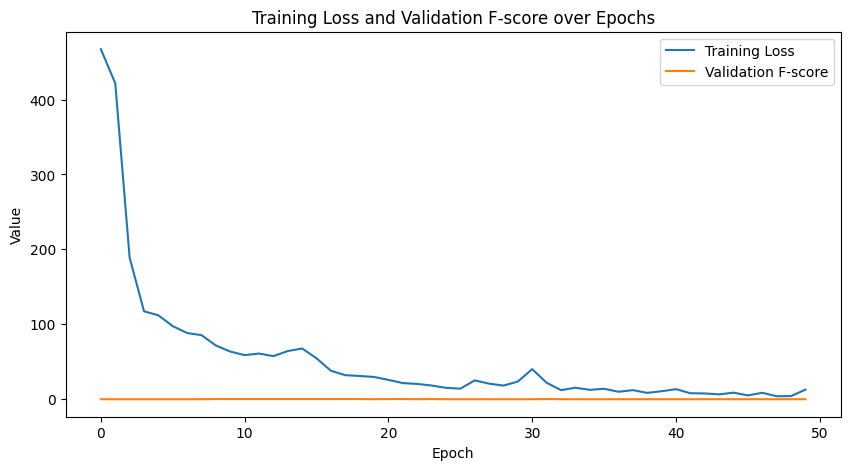

In [21]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random
import matplotlib.pyplot as plt

# Load a blank English model
nlp = spacy.blank("en")

# Add the NER component to the pipeline
ner = nlp.add_pipe("ner")

# Define your training examples with correct entity offsets
examples = [
    ("I need a green SUV under $20,000.", {"entities": [(9, 14, "COLOR"), (15, 18, "Body"), (24, 31, "PRICE")]}),
    ("Show me a blue sedan for $25,000.", {"entities": [(10, 14, "COLOR"), (15, 20, "Body"), (25, 32, "PRICE")]}),
    ("Can you find me a red 4x4 around $50,000?", {"entities": [(18, 21, "COLOR"), (22, 25, "Body"), (33, 40, "PRICE")]}),
    ("Do you have silver trucks below $30,000?", {"entities": [(12, 18, "COLOR"), (19, 25, "Body"), (32, 39, "PRICE")]}),
    ("I'm interested in luxury SUVs costing $60,000.", {"entities": [(16, 22, "Body"), (31, 38, "PRICE")]}),
    ("Can I buy a car for less than $15,000?", {"entities": [(20, 27, "PRICE")]}),
    ("Find me a white sedan priced under $40,000.", {"entities": [(10, 15, "COLOR"), (16, 21, "Body"), (34, 41, "PRICE")]}),
    ("Are there black SUVs costing above $70,000?", {"entities": [(10, 15, "COLOR"), (16, 19, "Body"), (33, 40, "PRICE")]}),
    ("Can you show me an orange hatchback for $18,000?", {"entities": [(19, 25, "COLOR"), (26, 35, "Body"), (40, 47, "PRICE")]}),
    ("I'm looking for something costing between $25,000 and $50,000.", {"entities": [(41, 48, "PRICE"), (53, 60, "PRICE")]}),
    # Additional examples you provided
    ("I'm looking for a 2018 Toyota Camry with less than 50,000 miles.", {"entities": [(18, 22, "YEAR"), (23, 29, "MAKE"), (30, 35, "MODEL"), (47, 60, "MILES")]}),
    ("Do you have any electric SUVs?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 28, "Body")]}),
    ("Can I get a 2-door coupe in red color?", {"entities": [(13, 19, "DOORS"), (20, 25, "Body"), (29, 32, "COLOR")]}),
    ("I'm interested in a black sedan with V6 engine.", {"entities": [(18, 23, "COLOR"), (24, 29, "Body"), (35, 37, "EngineCylinders")]}),
    ("Find me a used 2017 Ford F-150 with less than 60,000 miles and four-wheel drive.", {"entities": [(10, 14, "TYPE"), (15, 19, "YEAR"), (20, 24, "MAKE"), (25, 30, "MODEL"), (46, 59, "MILES"), (64, 79, "DRIVETRAIN")]}),
    ("Looking for a diesel truck with at least 400 horsepower.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (38, 51, "Engine_Description")]}),
    ("Do you have any cars with seating for 7 passengers?", {"entities": [(16, 20, "Body"), (32, 43, "PassengerCapacity")]}),
    ("I'm interested in a compact SUV with good city MPG.", {"entities": [(18, 25, "Body"), (36, 45, "CityMPG")]}),
    ("I want a car with a sunroof and Bluetooth connectivity.", {"entities": [(9, 12, "Body"), (20, 27, "OPTIONS"), (32, 52, "OPTIONS")]}),
    ("Find me a 2015 or newer sedan under $15,000.", {"entities": [(9, 23, "YEAR"), (24, 29, "Body"), (36, 43, "PRICE")]}),
    ("I'd like an all-wheel-drive crossover with a panoramic sunroof.", {"entities": [(10, 25, "DRIVETRAIN"), (26, 35, "Body"), (44, 61, "OPTIONS")]}),
    ("Show me vehicles with VIN number ending in 1234.", {"entities": [(8, 16, "Body"), (34, 38, "VIN")]}),
    ("I need a vehicle with at least 300 horsepower.", {"entities": [(9, 16, "Body"), (27, 40, "Engine_Description")]}),
    ("Looking for a hybrid sedan with high highway MPG.", {"entities": [(14, 20, "FUEL_TYPE"), (21, 26, "Body"), (37, 48, "HighwayMPG")]}),
    ("Can you find me a luxury SUV with premium sound system?", {"entities": [(18, 22, "Body"), (28, 48, "OPTIONS")]}),
    ("I prefer a manual transmission sports car.", {"entities": [(10, 29, "TRANSMISSION"), (30, 40, "Body")]}),
    ("Do you have any certified pre-owned vehicles?", {"entities": [(16, 38, "Certified"), (39, 47, "Body")]}),
    ("I'm looking for a vehicle in stock number ABC123.", {"entities": [(18, 25, "Body"), (40, 46, "Stock")]}),
    ("Find me an SUV with engine displacement over 3.0L.", {"entities": [(11, 14, "Body"), (20, 42, "EngineDisplacement")]}),
    ("I want a car with automatic transmission and navigation system.", {"entities": [(9, 12, "Body"), (18, 39, "TRANSMISSION"), (44, 61, "OPTIONS")]}),
    ("Looking for a blue hatchback with less than 30,000 miles.", {"entities": [(14, 18, "COLOR"), (19, 28, "Body"), (40, 53, "MILES")]}),
    ("I'm seeking a vehicle no older than 2015 with under 80,000 miles.", {"entities": [(18, 25, "Body"), (39, 43, "YEAR"), (54, 67, "MILES")]}),
    ("Do you have any SUVs priced between $30,000 and $45,000?", {"entities": [(16, 19, "Body"), (35, 42, "PRICE"), (47, 54, "PRICE")]}),
    ("Looking for a sedan with over 200 horsepower.", {"entities": [(14, 19, "Body"), (25, 38, "Engine_Description")]}),
    ("Can I find a coupe that's no less than $25,000?", {"entities": [(14, 19, "Body"), (36, 43, "PRICE")]}),
    ("I need a truck not exceeding $35,000 with at least 15 MPG city.", {"entities": [(9, 14, "Body"), (30, 37, "PRICE"), (50, 60, "CityMPG")]}),
    ("Show me convertibles costing no more than $50,000.", {"entities": [(8, 20, "Body"), (36, 43, "PRICE")]}),
    ("I'm interested in a 4-door sedan from 2018 or newer.", {"entities": [(18, 24, "DOORS"), (25, 30, "Body"), (36, 49, "YEAR")]}),
    ("Find me an SUV with a wheelbase longer than 110 inches.", {"entities": [(11, 14, "Body"), (36, 47, "Wheelbase_Code")]}),
    ("Do you have any cars with engine displacement below 2.5L?", {"entities": [(16, 20, "Body"), (26, 48, "EngineDisplacement")]}),
    ("Looking for a minivan that's no more than 5 years old.", {"entities": [(14, 21, "Body"), (38, 49, "YEAR")]}),
    ("Can I get a vehicle with less than 50,000 miles and priced under $20,000?", {"entities": [(13, 20, "Body"), (32, 45, "MILES"), (59, 66, "PRICE")]}),
    ("I'm after a luxury sedan with a top speed exceeding 150 mph.", {"entities": [(14, 19, "Body"), (41, 52, "Engine_Description")]}),
    ("Show me trucks that are no older than 2016 and under $40,000.", {"entities": [(8, 14, "Body"), (32, 36, "YEAR"), (47, 54, "PRICE")]}),
    ("Do you have any cars not older than 3 years with Bluetooth?", {"entities": [(16, 20, "Body"), (34, 39, "YEAR"), (45, 54, "OPTIONS")]}),
    ("I'm interested in an SUV with seating for no less than 6 people.", {"entities": [(18, 21, "Body"), (43, 44, "PassengerCapacity")]}),
    ("Find me a vehicle with a fuel efficiency of at least 30 MPG highway.", {"entities": [(9, 16, "Body"), (44, 56, "HighwayMPG")]}),
    ("Looking for a hatchback priced at no more than $25,000.", {"entities": [(14, 23, "Body"), (40, 47, "PRICE")]}),
    ("Can you show me cars with a towing capacity over 5,000 lbs?", {"entities": [(17, 21, "Body"), (29, 53, "Engine_Description")]}),
    ("I need an all-wheel-drive vehicle with less than 70,000 miles.", {"entities": [(9, 25, "DRIVETRAIN"), (26, 33, "Body"), (45, 58, "MILES")]}),
    ("Do you have any electric cars under $35,000 with fast charging?", {"entities": [(16, 24, "FUEL_TYPE"), (25, 29, "Body"), (36, 43, "PRICE"), (49, 62, "OPTIONS")]}),
    # New examples covering additional columns
    ("I'm looking for a pickup truck with 4WD, leather seats, and under 50,000 km.", {"entities": [(18, 30, "Body"), (36, 39, "DRIVETRAIN"), (41, 54, "OPTIONS"), (65, 75, "MILES")]}),
    ("Do you have a sporty car with a sunroof and under 50,000 km?", {"entities": [(16, 19, "Body"), (29, 36, "OPTIONS"), (47, 57, "MILES")]}),
    ("Do you have a red convertible under 30,000 km?", {"entities": [(13, 16, "COLOR"), (17, 28, "Body"), (35, 45, "MILES")]}),
    ("Do you have a family SUV with leather seats and low mileage?", {"entities": [(16, 19, "Body"), (25, 38, "OPTIONS"), (43, 55, "MILES")]}),
    ("Do you have an electric car with a range of at least 300 miles and advanced safety features?", {"entities": [(13, 21, "FUEL_TYPE"), (22, 25, "Body"), (47, 58, "MILES"), (63, 89, "OPTIONS")]}),
    ("I'm looking for an SUV with captain's chairs and a panoramic sunroof.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS"), (49, 65, "OPTIONS")]}),
    ("Do you have a minivan with stow-and-go seating and rear-seat entertainment?", {"entities": [(13, 20, "Body"), (26, 44, "OPTIONS"), (49, 73, "OPTIONS")]}),
    ("I'm looking for a high-performance car with launch control and Brembo brakes.", {"entities": [(18, 22, "Body"), (29, 47, "Engine_Description"), (53, 67, "OPTIONS"), (72, 86, "OPTIONS")]}),
    ("Do you have the car with VIN 1HGCM82633A123456?", {"entities": [(16, 19, "Body"), (29, 46, "VIN")]}),
    ("I'm looking for the car with VIN 5FNYF6H57LB789012.", {"entities": [(21, 24, "Body"), (34, 51, "VIN")]}),
    ("Do you have an SUV with off-road capabilities, a roof rack, and skid plates?", {"entities": [(13, 16, "Body"), (22, 43, "OPTIONS"), (47, 56, "OPTIONS"), (62, 73, "OPTIONS")]}),
    ("Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?", {"entities": [(13, 16, "Body"), (22, 34, "OPTIONS"), (38, 60, "OPTIONS"), (66, 81, "OPTIONS")]}),
    ("I'm looking for an SUV with third-row seating.", {"entities": [(18, 21, "Body"), (27, 42, "OPTIONS")]}),
    ("Do you have a hybrid SUV?", {"entities": [(13, 19, "FUEL_TYPE"), (20, 23, "Body")]}),
    ("I currently drive a 2018 Toyota Camry. Do you have anything similar?", {"entities": [(19, 23, "YEAR"), (24, 30, "MAKE"), (31, 36, "MODEL")]}),
    ("I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?", {"entities": [(15, 19, "YEAR"), (20, 27, "MAKE"), (28, 34, "MODEL"), (53, 57, "Body")]}),
    ("I want an electric car.", {"entities": [(9, 17, "FUEL_TYPE"), (18, 21, "Body")]}),
    ("I'm looking for a fun car to drive.", {"entities": [(18, 21, "Body")]}),
]

# Add labels to the NER component
for _, annotations in examples:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Convert training examples to spaCy's Example objects
training_data = []
for text, annotations in examples:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    training_data.append(example)

# Begin training
nlp.begin_training()
# You can set a seed for reproducibility
random.seed(42)
spacy.util.fix_random_seed(42)

# Let's split the data into training and validation sets
split = int(len(training_data) * 0.8)
train_data = training_data[:split]
valid_data = training_data[split:]

# Tracking losses and validation scores
train_losses = []
valid_f_scores = []

for epoch in range(50):
    random.shuffle(train_data)
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))
    for batch in batches:
        nlp.update(
            batch,
            drop=0.35,
            losses=losses
        )
    train_losses.append(losses.get('ner', 0.0))
    
    # Evaluate on validation data
    examples = []
    for example in valid_data:
        pred_doc = nlp(example.reference.text)
        examples.append(Example(predicted=pred_doc, reference=example.reference))
    # Calculate F-score
    scorer = spacy.scorer.Scorer()
    scores = scorer.score(examples)
    valid_f_scores.append(scores['ents_f'])
    
    print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]:.4f}, Validation F-score: {valid_f_scores[-1]:.2f}")

# Plot the training loss and validation F-score
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_f_scores, label='Validation F-score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss and Validation F-score over Epochs')
plt.show()

# Save the model
nlp.to_disk("custom_ner_model")


In [23]:
import spacy

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Define test cases (only Q parts are used for entity extraction)
test_cases = [
    "I need a pickup truck with 4WD, leather seats, and under 50,000 km.",
    "Do you have a sporty car with a sunroof and under 50,000 km?",
    "Do you have a red convertible under 30,000 km?",
    "Do you have a family SUV with leather seats and low mileage?",
    "Do you have an electric car with a range of at least 300 miles and advanced safety features?",
    "I'm looking for an SUV with captain's chairs and a panoramic sunroof.",
    "Do you have a minivan with stow-and-go seating and rear-seat entertainment?",
    "I'm looking for a high-performance car with launch control and Brembo brakes.",
    "Do you have the car with VIN 1HGCM82633A123456?",
    "I'm looking for the car with VIN 5FNYF6H57LB789012.",
    "Do you have an SUV with off-road capabilities, a roof rack, and skid plates?",
    "Do you have an SUV with remote start, a heated steering wheel, and a power liftgate?",
    "I'm looking for an SUV with third-row seating.",
    "Do you have a hybrid SUV?",
    "I want something fun to drive.",
    "I currently drive a 2018 Toyota Camry. Do you have anything similar?",
    "I'm driving a 2018 Hyundai Tucson right now. Any similar SUVs in stock?",
    "I'm looking for a fun car to drive.",
    "I want an electric car.",
]

# Test the model with the cases
for i, sentence in enumerate(test_cases, start=1):
    doc = nlp(sentence)
    print(f"Test Case {i}:")
    print(f"Sentence: {sentence}")
    print("Entities:")
    for ent in doc.ents:
        print(f" - {ent.text}: {ent.label_}")
    print("\n" + "-"*50 + "\n")



Test Case 1:
Sentence: I need a pickup truck with 4WD, leather seats, and under 50,000 km.
Entities:
 - pickup truck: BODY_TYPE
 - 4WD: DRIVETRAIN
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 2:
Sentence: Do you have a sporty car with a sunroof and under 50,000 km?
Entities:
 - sporty: BODY_TYPE
 - sunroof: OPTIONS

--------------------------------------------------

Test Case 3:
Sentence: Do you have a red convertible under 30,000 km?
Entities:
 - red: COLOR
 - convertible: BODY_TYPE

--------------------------------------------------

Test Case 4:
Sentence: Do you have a family SUV with leather seats and low mileage?
Entities:
 - family: BODY_TYPE
 - leather seats: OPTIONS

--------------------------------------------------

Test Case 5:
Sentence: Do you have an electric car with a range of at least 300 miles and advanced safety features?
Entities:
 - electric: FUEL_TYPE
 - car: BODY_TYPE
 - range: BODY_TYPE
 - safety: BODY_TYPE

----------